In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
from matplotlib.lines import Line2D
sns.set_context('paper')
pd.set_option('display.max_columns', None)

In [2]:
with open("../Data/simu2_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)

In [3]:
df_study

,list_uni,itemno,study_pos,session
0,48,1328,1,0
1,48,768,2,0
2,48,518,3,0
3,48,21,4,0
4,48,914,5,0
...,...,...,...,...
63995,279,801,60,999
63996,279,997,61,999
63997,279,1186,62,999
63998,279,1279,63,999


In [4]:
df_test

,list_uni,recog_pos,itemno,old,old_lag,study_pos,study_lag,session
0,48,1,490,True,-999,52,13,0
1,48,2,541,True,9,61,5,0
2,48,3,1066,False,-999,-99,-9999,0
3,48,4,942,True,-999,34,34,0
4,48,5,1464,False,-999,-99,-9999,0
...,...,...,...,...,...,...,...,...
127995,279,124,530,True,-4,26,162,999
127996,279,125,357,False,-999,-99,-9999,999
127997,279,126,307,False,-999,-99,-9999,999
127998,279,127,1349,False,-999,-99,-9999,999


### Run CMR-IA

In [5]:
s_mat = np.load("../Data/simu2_smat.npy")
# s_mat = np.identity(np.max(df.itemno)) # identity semantic matrix
# s_mat

In [6]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.4,
    beta_cue = 0.5,
    beta_distract = 0.95,
    gamma_fc = 0.05,
    s_fc = 0.9,
    c_thresh = 0.377,
)
params

{'beta_enc': 0.4,
 'beta_rec': 0.5,
 'beta_cue': 0.5,
 'beta_rec_post': 0,
 'beta_distract': 0.95,
 'phi_s': 2,
 'phi_d': 0.5,
 's_cf': 0,
 's_fc': 0.9,
 'kappa': 0.5,
 'eta': 0.5,
 'omega': 8,
 'alpha': 1,
 'c_thresh': 0.377,
 'c_thresh_ass': 0.5,
 'd_ass': 1,
 'lamb': 0.5,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 50,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 2.14,
 'm': 0,
 'n': 1,
 'c1': 0,
 'No_recall': None,
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.05,
 'gamma_cf': 0.5}

In [7]:
df_simu = cmr.run_norm_recog_multi_sess(params,df_study,df_test,s_mat)
df_simu

CMR Time: 62.06751203536987


,session,itemno,s_resp,s_rt,csim
0,0,490,0.0,1696.970459,0.142993
1,0,541,0.0,2336.997559,0.292536
2,0,1066,0.0,2543.146729,0.332039
3,0,942,1.0,2730.087402,0.388816
4,0,1464,1.0,2751.304932,0.385198
...,...,...,...,...,...
127995,999,530,1.0,2648.385986,0.403014
127996,999,357,1.0,2434.743408,0.442317
127997,999,307,0.0,2661.200684,0.353242
127998,999,1349,1.0,2592.120361,0.413048


In [8]:
df_simu = df_simu.merge(df_test,on=['session','itemno'])
df_simu

,session,itemno,s_resp,s_rt,csim,list_uni,recog_pos,old,old_lag,study_pos,study_lag
0,0,490,0.0,1696.970459,0.142993,48,1,True,-999,52,13
1,0,541,0.0,2336.997559,0.292536,48,2,True,9,61,5
2,0,1066,0.0,2543.146729,0.332039,48,3,False,-999,-99,-9999
3,0,942,1.0,2730.087402,0.388816,48,4,True,-999,34,34
4,0,1464,1.0,2751.304932,0.385198,48,5,False,-999,-99,-9999
...,...,...,...,...,...,...,...,...,...,...,...
127995,999,530,1.0,2648.385986,0.403014,279,124,True,-4,26,162
127996,999,357,1.0,2434.743408,0.442317,279,125,False,-999,-99,-9999
127997,999,307,0.0,2661.200684,0.353242,279,126,False,-999,-99,-9999
127998,999,1349,1.0,2592.120361,0.413048,279,127,False,-999,-99,-9999


### ROC

In [9]:
def conditions(s):
    if s.old_lag == -999:
        return np.nan
    elif np.absolute(s.old_lag) == 1:
        return 'a'
    elif np.absolute(s.old_lag) > 10:
        return 'r'
    else:
        return np.nan
df_simu['lag_cat'] = df_simu.apply(conditions, axis=1)
df_simu

,session,itemno,s_resp,s_rt,csim,list_uni,recog_pos,old,old_lag,study_pos,study_lag,lag_cat
0,0,490,0.0,1696.970459,0.142993,48,1,True,-999,52,13,NaN
1,0,541,0.0,2336.997559,0.292536,48,2,True,9,61,5,NaN
2,0,1066,0.0,2543.146729,0.332039,48,3,False,-999,-99,-9999,NaN
3,0,942,1.0,2730.087402,0.388816,48,4,True,-999,34,34,NaN
4,0,1464,1.0,2751.304932,0.385198,48,5,False,-999,-99,-9999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
127995,999,530,1.0,2648.385986,0.403014,279,124,True,-4,26,162,NaN
127996,999,357,1.0,2434.743408,0.442317,279,125,False,-999,-99,-9999,NaN
127997,999,307,0.0,2661.200684,0.353242,279,126,False,-999,-99,-9999,NaN
127998,999,1349,1.0,2592.120361,0.413048,279,127,False,-999,-99,-9999,NaN


In [10]:
for i in range(1, len(df_simu)):
    if df_simu.loc[i, 'old'] == False and df_simu.loc[i-1, 'old'] == True:
        df_simu.loc[i, 'lag_cat'] = df_simu.loc[i-1, 'lag_cat']
df_simu

,session,itemno,s_resp,s_rt,csim,list_uni,recog_pos,old,old_lag,study_pos,study_lag,lag_cat
0,0,490,0.0,1696.970459,0.142993,48,1,True,-999,52,13,NaN
1,0,541,0.0,2336.997559,0.292536,48,2,True,9,61,5,NaN
2,0,1066,0.0,2543.146729,0.332039,48,3,False,-999,-99,-9999,NaN
3,0,942,1.0,2730.087402,0.388816,48,4,True,-999,34,34,NaN
4,0,1464,1.0,2751.304932,0.385198,48,5,False,-999,-99,-9999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
127995,999,530,1.0,2648.385986,0.403014,279,124,True,-4,26,162,NaN
127996,999,357,1.0,2434.743408,0.442317,279,125,False,-999,-99,-9999,NaN
127997,999,307,0.0,2661.200684,0.353242,279,126,False,-999,-99,-9999,NaN
127998,999,1349,1.0,2592.120361,0.413048,279,127,False,-999,-99,-9999,NaN


In [11]:
df_t = df_simu.loc[pd.notna(df_simu.lag_cat)].copy()
df_t

,session,itemno,s_resp,s_rt,csim,list_uni,recog_pos,old,old_lag,study_pos,study_lag,lag_cat
6,0,1163,1.0,2532.549072,0.423913,48,7,True,13,25,46,r
7,0,851,1.0,2366.470215,0.455607,48,8,True,25,50,22,r
34,0,1491,1.0,2649.810303,0.402762,48,35,True,44,46,53,r
35,0,1076,1.0,2601.724121,0.411320,48,36,True,-22,24,76,r
36,0,37,1.0,2343.461426,0.460173,48,37,True,29,53,48,r
...,...,...,...,...,...,...,...,...,...,...,...,...
127986,999,1322,1.0,2555.178711,0.419756,279,115,True,-48,15,164,r
127987,999,390,1.0,2765.425293,0.382806,279,116,False,-999,-99,-9999,r
127989,999,1118,1.0,2557.339600,0.419361,279,118,True,-32,12,170,r
127990,999,947,1.0,2382.687500,0.452416,279,119,True,43,55,128,r


In [12]:
create_level = {0:"new r", 1:"new a", 2:"old r", 3:"old a"}
df_t['level'] = df_t.apply(lambda x: create_level[x['old'] * 2 + (x['lag_cat'] == 'a')], axis = 1)
df_t

,session,itemno,s_resp,s_rt,csim,list_uni,recog_pos,old,old_lag,study_pos,study_lag,lag_cat,level
6,0,1163,1.0,2532.549072,0.423913,48,7,True,13,25,46,r,old r
7,0,851,1.0,2366.470215,0.455607,48,8,True,25,50,22,r,old r
34,0,1491,1.0,2649.810303,0.402762,48,35,True,44,46,53,r,old r
35,0,1076,1.0,2601.724121,0.411320,48,36,True,-22,24,76,r,old r
36,0,37,1.0,2343.461426,0.460173,48,37,True,29,53,48,r,old r
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127986,999,1322,1.0,2555.178711,0.419756,279,115,True,-48,15,164,r,old r
127987,999,390,1.0,2765.425293,0.382806,279,116,False,-999,-99,-9999,r,new r
127989,999,1118,1.0,2557.339600,0.419361,279,118,True,-32,12,170,r,old r
127990,999,947,1.0,2382.687500,0.452416,279,119,True,43,55,128,r,old r


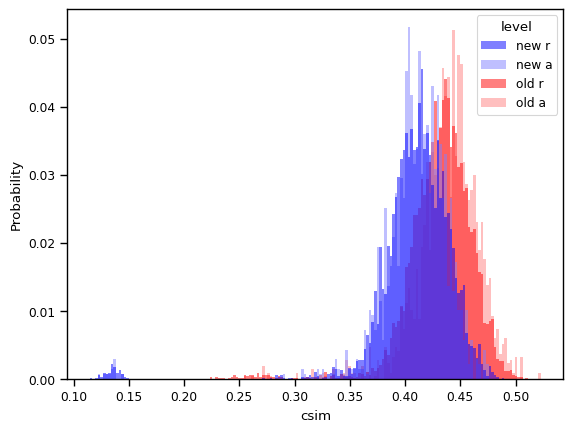

In [13]:
sns.histplot(data=df_t, x="csim", hue = "level", hue_order = ["new r", "new a", "old r", "old a"], palette = [[0,0,1],[0.5,0.5,1],[1,0,0],[1,0.5,0.5]], stat = "probability", common_norm = False,edgecolor=None)
plt.savefig('fig/simu2_csim.pdf')

In [14]:
thresh_arr = np.arange(0,1,0.004)
df_th = df_t.loc[:,['csim','level']]
df_roc = pd.DataFrame()
for t in thresh_arr:
    df_th['above'] = df_th.csim > t
    tmp = df_th.groupby("level").above.mean()
    # print(tmp)
    df_roc = pd.concat([df_roc,tmp],axis=1,ignore_index=True)
df_roc = df_roc.transpose()
df_roc

,new a,new r,old a,old r
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0
...,...,...,...,...
245,0.0,0.0,0.0,0.0
246,0.0,0.0,0.0,0.0
247,0.0,0.0,0.0,0.0
248,0.0,0.0,0.0,0.0


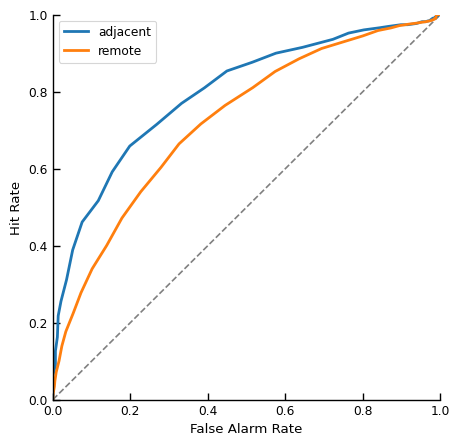

In [15]:
fig, ax = plt.subplots(figsize = (5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
x = np.array([0,1])
y = np.array([0,1])
ax.plot(x,y,color='grey',linestyle='dashed')
sns.lineplot(data=df_roc, x="new a", y = "old a", marker = None, ax=ax, estimator = None, label = 'adjacent', linewidth = 2)
sns.lineplot(data=df_roc, x="new r", y = "old r", marker = None, ax=ax, estimator = None, label = 'remote', linewidth = 2)
plt.ylim([0,1])
plt.xlim([0,1])
plt.xlabel("False Alarm Rate")
plt.ylabel("Hit Rate")
ticks = np.array([0,0.2,0.4,0.6,0.8,1])
plt.xticks(ticks=ticks)
plt.yticks(ticks=ticks)
plt.legend()
plt.savefig('fig/simu2_roc.pdf')
plt.show()

In [16]:
df_zroc = pd.DataFrame()
df_zroc['z_new_a'] = sp.stats.norm.ppf(df_roc['new a'])
df_zroc['z_new_r'] = sp.stats.norm.ppf(df_roc['new r'])
df_zroc['z_old_a'] = sp.stats.norm.ppf(df_roc['old a'])
df_zroc['z_old_r'] = sp.stats.norm.ppf(df_roc['old r'])
df_zroc

,z_new_a,z_new_r,z_old_a,z_old_r
0,inf,inf,inf,inf
1,inf,inf,inf,inf
2,inf,inf,inf,inf
3,inf,inf,inf,inf
4,inf,inf,inf,inf
...,...,...,...,...
245,-inf,-inf,-inf,-inf
246,-inf,-inf,-inf,-inf
247,-inf,-inf,-inf,-inf
248,-inf,-inf,-inf,-inf


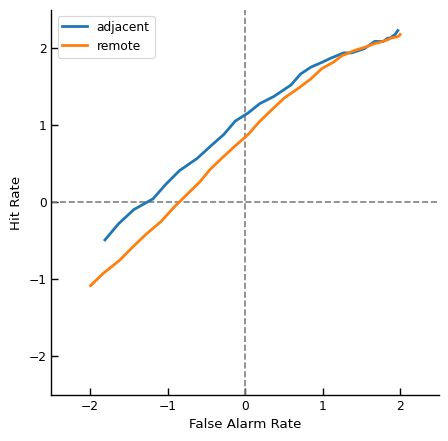

In [17]:
fig, ax = plt.subplots(figsize = (5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.axvline(x = 0, color='grey',linestyle='dashed')
plt.axhline(y = 0, color='grey',linestyle='dashed')
sns.lineplot(data=df_zroc.loc[(df_zroc.z_new_a < 2) & (-2 < df_zroc.z_new_a)], x="z_new_a", y = "z_old_a", marker = None, ax=ax, estimator = None, label = 'adjacent', linewidth = 2)
sns.lineplot(data=df_zroc.loc[(df_zroc.z_new_r < 2) & (-2 < df_zroc.z_new_r)], x="z_new_r", y = "z_old_r", marker = None, ax=ax, estimator = None, label = 'remote', linewidth = 2)
plt.ylim([-2.5,2.5])
plt.xlim([-2.5,2.5])
plt.xlabel("False Alarm Rate")
plt.ylabel("Hit Rate")
plt.legend()
plt.savefig('fig/simu2_zroc.pdf')
plt.show()